<a href="https://colab.research.google.com/github/Blistt/Image-Retrieval/blob/main/ArtisticSimilarity_G.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Get dataset from Kaggle (requires json key for the dataset)

In [ ]:
!cp '/content/drive/MyDrive/Kaggle/kaggle.json' '/content'
import zipfile
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:
!kaggle datasets download -d mylesoneill/tagged-anime-illustrations

100% 35.6G/35.6G [07:41<00:00, 118MB/s]
100% 35.6G/35.6G [07:41<00:00, 82.8MB/s]


In [ ]:
zip_ref = zipfile.ZipFile('tagged-anime-illustrations.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/content') #Extracts the files into the /kaggle folder
zip_ref.close()

Load images

In [ ]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from google.colab import files
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array


view_images = []
images = []

def load_images(images, path):
  for i, img in enumerate(os.listdir(path)):
    img = tf.keras.preprocessing.image.load_img(os.path.join(path,img), target_size=(224,224))
    view_images.append(img)
    img = np.expand_dims(img, axis=0)
    # Pre-processes image
    img = tf.keras.applications.vgg19.preprocess_input(img)
    images.append(img)
    print(i)
  return len(os.listdir(path))

def load_images3(images, path):
  for i, img in enumerate(os.listdir(path)):
    img = tf.keras.preprocessing.image.load_img(os.path.join(path,img), target_size=(224,224))
    view_images.append(img)
    img = img_to_array(img)
    img=img/np.amax(img)
    images.append(img)
    print(i)
  return len(os.listdir(path))

# Load 'train' dataset
load_images(images, '/content/drive/MyDrive/A-Photos/')
# Load test dataset
test_size = load_images(images, '/content/drive/MyDrive/favs/')
print(test_size)



print(len(images), 'images loaded')

Load model

In [ ]:
from keras import backend as K 

model = tf.keras.applications.VGG19(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",)

model.summary()

layer_outputs = [layer.output for layer in model.layers[1:-2]]
visual_model = tf.keras.models.Model(inputs = model.input, outputs = layer_outputs)

574726144/574710816 [==============================] - 2s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

Obtain feature maps

In [ ]:
def get_embeddings(f_levels):
  # Initialize embeddings
  E = []
  for i, img in enumerate(images):
    # run an image through the network by making a prediction
    feature_maps = visual_model.predict(img)
    
    layer_names = [layer.name for layer in model.layers[1:]]

    temp = np.zeros((0))
    for level in f_levels:
      A = feature_maps[level]
      # Flatten feature map to 2x2 matrix
      A = A.reshape(A.shape[0], A.shape[1]*A.shape[2], A.shape[3], order='F')
      A = A.reshape(A.shape[1],A.shape[2])
      # Compute Gram matrix (cummulative co-activation of filter per layer)
      G = np.matmul(np.transpose(A),A)
      # Append this layer's flattened Gram matrix to images embedding
      dummy = np.zeros(temp.shape[0] + G.flatten().shape[0])
      dummy[:temp.shape[0]] = temp
      dummy[temp.shape[0]:] = G.flatten()
      temp = np.copy(dummy) 

    E.append(np.copy(temp))

    if i%10 == 0:
      print(i, E[i].shape, len(f_levels))
    
  return np.array(E)

Create list of neighbors

In [ ]:
def get_neighbors(E, num_neighbors, index):
  knnbr = NearestNeighbors(n_neighbors = num_neighbors, algorithm = 'ball_tree').fit(E)
  return knnbr.kneighbors([E[index]])

Funciton to display images

In [ ]:
import matplotlib.pyplot as plt
from google.colab import files

def show_images(images, filename):
    # Display image in new window
    fig = plt.figure(figsize=(14, 8))

    for i in range(1, len(images)+1):
      ax = fig.add_subplot(len(images)/6, 6, i)
      if i == 1:
        ax.set_title('Query Image')
      else:
        title = 'neighbor' + str(i-1)
        ax.set_title(title)

      plt.imshow(images[i-1])
      plt.axis('off')
    plt.show()



Color Histograms

In [ ]:
def color_histogram_1D(images,bins=32):
  H = []
  for i, im in enumerate(images):
    h = []
    for j in range(im.shape[2]):
        hist, bins = np.histogram(im[:,:,j], bins=bins, density=True, range=(0,1))

        h.append(hist)
    H.append(np.array(h).flatten())
    print(i)
  return np.array(H)

Obtain embeddings and nearest neighbors

In [ ]:
# Select the layer from which to extract feature maps (conv1_1 is layer 0)
f_levels = [0,3,6,11,16]

knn_images = [[]* (test_size+1) for i in range(test_size)]

E = get_embeddings(f_levels)

# E = color_histogram_1D(images)

print(E.shape[0])

knnbr = NearestNeighbors(n_neighbors = 6, algorithm = 'ball_tree').fit(E)

# Iterate throug all test images (last X images of dataset)
test_start = E.shape[0] - test_size
for k in range(test_start, E.shape[0]):
  knn = knnbr.kneighbors([E[k]])
          
  # Save images in a display list
  knn_disp = []
  for n in knn[1][0]:
    if n != k:
      knn_disp.append(view_images[n])

  imgs = [view_images[k], knn_disp[0], knn_disp[1], knn_disp[2], knn_disp[3], knn_disp[4]]

  for img in imgs:
    knn_images[k-test_start].append(img)

print('-----------------------------------------------------------')   

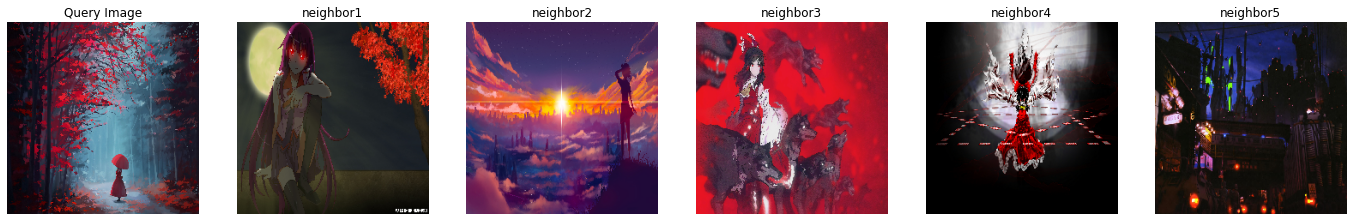

In [ ]:
show_images(knn_images[50], '1')

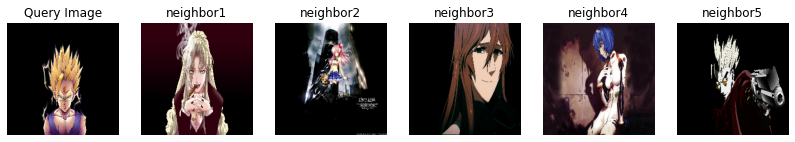

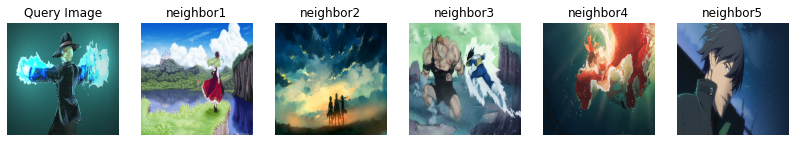

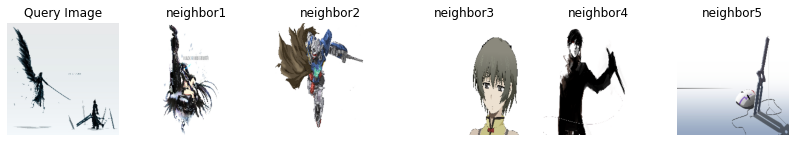

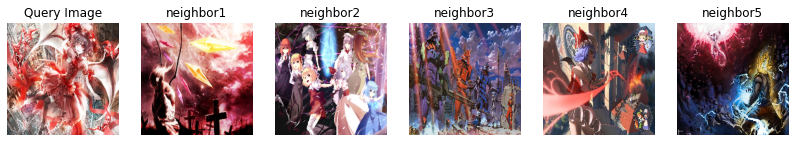

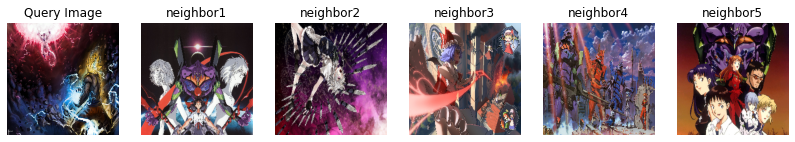

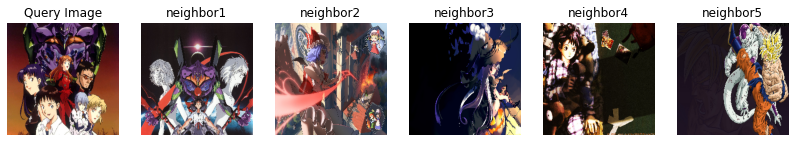

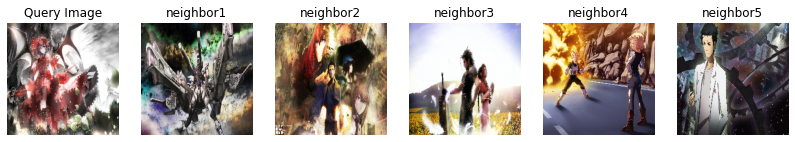

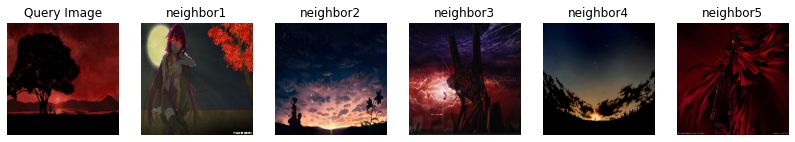

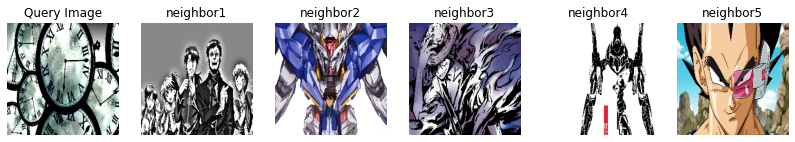

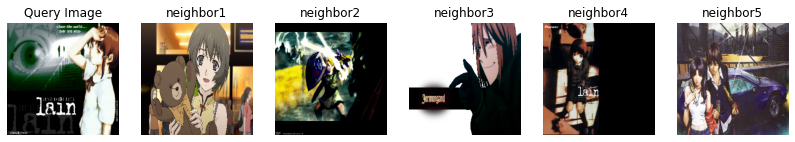

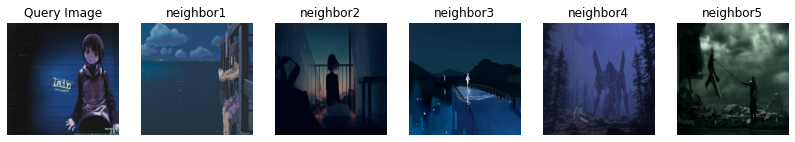

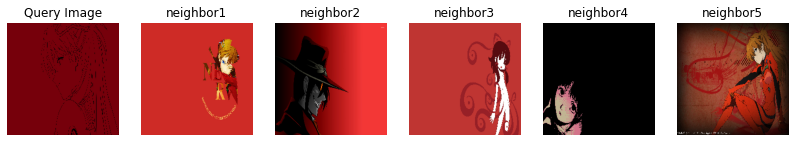

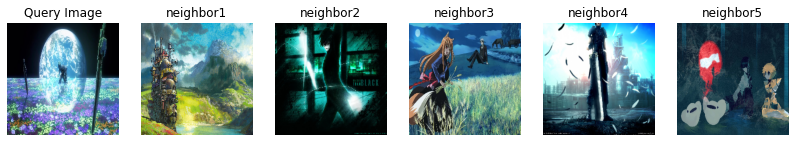

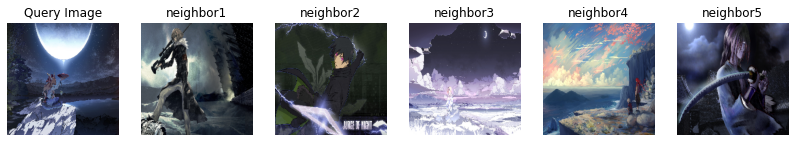

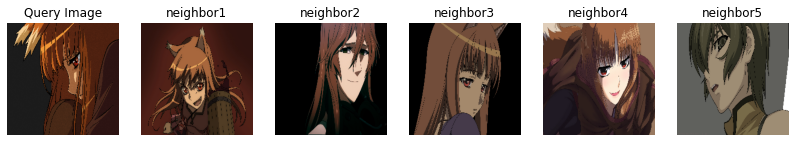

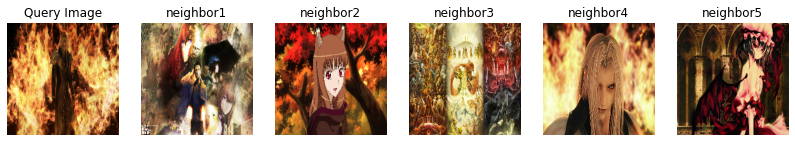

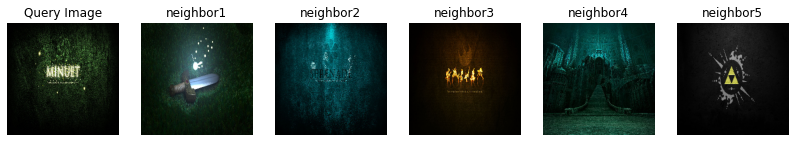

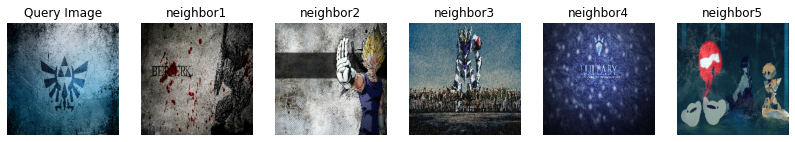

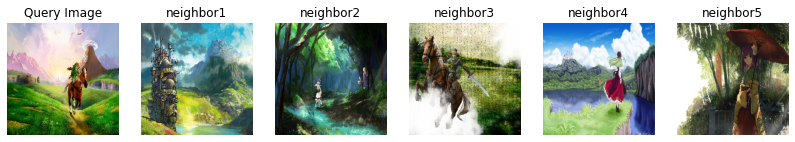

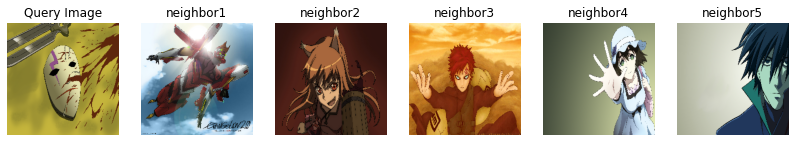

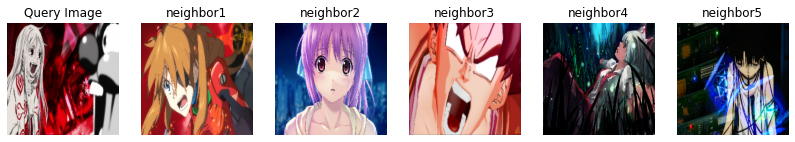

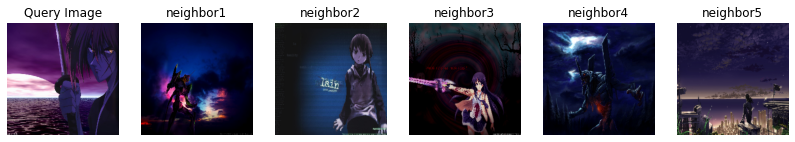

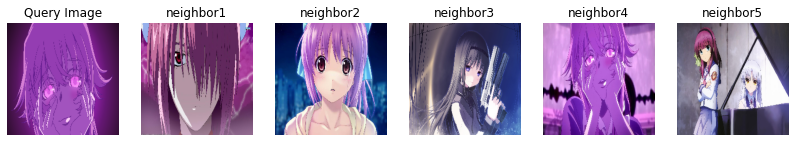

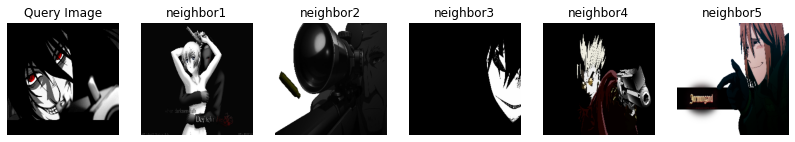

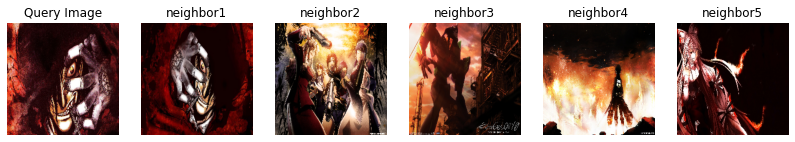

In [ ]:
for i, img in enumerate(knn_images[:25]):
  show_images(img, str(i))